# Chapter 11 - I2VIS - Clean version

This is an implementation of a 2D viscous flow code. The energy equation (for temperature) is solved at the cell centers (unlike the example in the chapter 10 notebook, which is solved at the basic nodes.

This notebook puts all of the major function definitions into separate source files and contains only the high-level program code.

In [1]:
# Import necessary packages
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
include("Grid.jl")
include("GridOperations.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")

# note that we import pyplot last to avoid a name conflict with grid.
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Problem setup

100 km sticky air layer, 500x500 km box
We define the materials used in this computation here.
We introduce functions that compute the density on the markers.
We introduce a function that computes the initial conditions (on the markers).

In [2]:
struct Materials
    # 1 - mantle
    # 2 - plume
    # 3 - sticky air
    alpha::Vector{Float64}
    rho0::Vector{Float64}
    Hr::Vector{Float64}
    Cp::Vector{Float64}
    kThermal::Vector{Float64}
    eta::Vector{Float64}
    function Materials()
         # These are the values used in Gerya's problem 11.1
         new([3e-5,2e-5,0.0],[3300.,3200.,1.0],[2e-8,3e-8,0.0],[1000.,1000.,3.3e6],[3.0,2.0,300.0],[1e21,1e20,1e17])
    end
end

function update_marker_density!(markers::Markers,materials::Materials)
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    
    for i in 1:markers.nmark                
        # receompute density using the current temperature value
        # assume reference temperature is 273.0
        markers.scalars[rho,i] = materials.rho0[mmat[i]] # don't update density - for comparison with gerya
        # materials.rho0[mmat[i]]*(1.0-materials.alpha[mmat[i]]*(markers.scalars[T,i]-273.0)) 
    end
end

function initial_conditions!(markers::Markers,materials::Materials)
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        mr = ((mx-2.5e5)^2 + (my-2.5e5)^2)^0.5
        if my < 1e5
             # sticky air
             markers.integers[material,i] = 3
             markers.scalars[T,i] = 273.0
             markers.scalars[eta,i] = materials.eta[3]
             markers.scalars[alpha,i] = materials.alpha[3]  
             markers.scalars[cp,i] = materials.Cp[3]  
             markers.scalars[Hr,i] = materials.Hr[3]  
         elseif mr < 1e5
             # plume
             markers.integers[material,i] = 2
             markers.scalars[T,i] = 1800.0
             markers.scalars[eta,i] = materials.eta[2]
             markers.scalars[alpha,i] = materials.alpha[2]            
             markers.scalars[cp,i] = materials.Cp[2]  
             markers.scalars[Hr,i] = materials.Hr[2]  
         else
            # ambient mantle
            markers.integers[material,i] = 1
            markers.scalars[T,i] = 1500.0            
            markers.scalars[eta,i] = materials.eta[1]
            markers.scalars[alpha,i] = materials.alpha[1]            
            markers.scalars[cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]  
         end
    end
    update_marker_density!(markers,materials)
end

initial_conditions! (generic function with 1 method)

# i2vis procedure

0. Set up the Eulerian grid and Lagrangian markers. Distribute the markers within the domain and assign initial conditions.
1. Compute density and viscosity at the basic nodes. Compute cell center viscosity via averaging.
2. Assemble and solve the Stokes equations.
3. Compute the maximum timestep from the velocity field and CFL number.
3. Transfer temperature from markers to basic nodes.
4. Compute the new temperature solution.
5. If the maximum temperature change exceeds a specified value, reduce the timstep and repeat previous step.
6. Compute the subgrid temperature changes and update the temperature on the markers.
7. Move the markers using 4th order Runge-Kutta

TO DO:
1. Calculate rhox (rho at vx points) -> (optionally) pass to Stokes.jl (Max)
3. Add free-surface stabilization terms to Stokes.jl (Lucy)
4. Add functionality for shear heating (Max)
5. Add functionality for adiabatic heating (Uthkarsh)

In [3]:
function run(nstep::Int64)
    nx = 101
    ny = 101
    W = 5e5
    H = 5e5
    gx = 0.0
    gy = 10.0

    Tbctype = [-1,-1,1,1] #left, right, top, bottom
    Tbcval = [0.0,0.0,273.0,1500.0]
    
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    materials = Materials()
    
    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","Cp","T","rho","eta","Hr"],["material"] ; nmx=markx,nmy=marky,random=true)
    println("Initial condition...")
    @time initial_conditions!(markers, materials)

    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 3.0 .*ones(grid.ny,grid.nx);

    time = 0.0
    iout=0
    last_plot = 0.0
    rho_c = nothing
    dt = 1e10

      local rho_c
      local rho_vx
      local rho_vy
      local alpha
      local Hr
      local Cp_c
      local eta_s
      local eta_n
      local vxc
      local vyc
      local T
      local dt
      local dTmax
      local dTemp
      local Tnew
      local Tlast

    output_dir = "test"
    for itime in 1:nstep
        # 1. Transfer properties markers -> nodes
        # 1a. Basic Nodes
        eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic");
        # 1b. Cell Centers
        rho_c_new,Cp_c_new,alpha_new,eta_n_new,Tlast_new,Hr_new = marker_to_stag(markers,grid,["rho","Cp","alpha","eta","T","Hr"],"center")
        # 1c. Vx and Vy nodes:
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy")
        # Get material at basic nodes:
        #mat_node = marker_to_stag(markers,grid,markers.integers[markers.integerFields["material"],:],"basic");
        
        # deal with any NaN values from interpolation:
        if itime > 1
            if any(isnan.(eta_s_new))
                println("found nan values")
            end
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Hr,Hr_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(eta_n,eta_n_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
        end
        # Copy field data 
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        rho_c = copy(rho_c_new)
        Hr = copy(Hr_new)
        Cp_c = copy(Cp_c_new)
        alpha = copy(alpha_new)
        eta_s = copy(eta_s_new)
        eta_n = copy(eta_n_new)
        Tlast = copy(Tlast_new)
    
        # 2. Assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy;dt=dt)
        stokes_solution = L\R
        vx,vy,P = unpack(stokes_solution,grid;ghost=true)
    
        # Get the velocity at the cell centers:
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        adiabatic_heating = compute_adiabatic_heating(grid,rho_c,Tlast,alpha,gx,gy,vxc,vyc)
        shear_heating = compute_shear_heating(grid,vx,vy,eta_n,eta_s)
        H = (adiabatic_heating .+ shear_heating .+ Hr)
    
        # 3. Compute the advection timestep:
        if itime > 1
            this_dtmax = min(1.2*dt,dtmax)
        else
            this_dtmax = dtmax
        end
        dt = compute_timestep(grid,vxc,vyc ; dtmax=this_dtmax)
        
        dTmax = Inf
        dTemp = nothing
        Tnew = nothing
        titer=1
        for titer=1:2# limit maximum temperature change
            # assemble and solve the energy equation
            println("Trying with timestep ",dt/3.15e7/1e6," Myr")
            L,R = assemble_energy_equation_center(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbcval);
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbctype,Tbcval);

            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp))
            println("dTmax=",dTmax," dt=",dt/3.15e7/1e6)
            dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
            if dTmax < 10.0
                break
            end
        end

        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp_c[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node

        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")

        if time == 0.0 || time - last_plot >= plot_interval
            last_plot = time 
            name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
            println("Writing visualization fle ",name)
            vn = velocity_to_basic_nodes(grid,vxc,vyc)

        visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
            name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
            visualization(markers,time/seconds_in_year;filename=name)
            iout += 1
        end
        
        println("Min/Max velocity: ",minimum(vyc)," ",maximum(vyc))
        move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
        time += dt
        println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr")
    end
    return grid,markers,vxc,vyc,rho_c,eta_n,Tnew,time
end
@time grid,markers,vxc,vyc,rho_c,eta_n,Tnew,time = run(1)


Creating Markers...
  0.009643 seconds (19 allocations: 33.784 MiB)
Initial condition...
  0.192048 seconds (1.14 M allocations: 20.655 MiB, 24.91% gc time, 32.03% compilation time: 28% of which was recompilation)
Trying with timestep 0.0206914794988418 Myr
dTmax=26.072848210267694 dt=0.0206914794988418
Trying with timestep 0.007936025758280346 Myr
dTmax=26.042541623239913 dt=0.007936025758280346
Writing visualization fle test/viz.0000.vtr
  0.002766 seconds (2 allocations: 5.493 MiB)
Min/Max velocity: -3.835640625385043e-9 2.228255601831305e-9
Finished Step 1 time=0.0030473315059227446 Myr
  8.266555 seconds (4.89 M allocations: 621.187 MiB, 4.97% gc time, 65.89% compilation time: 2% of which was recompilation)


(CartesianGrid([0.0, 5000.0, 10000.0, 15000.0, 20000.0, 25000.0, 30000.0, 35000.0, 40000.0, 45000.0  …  455000.0, 460000.0, 465000.0, 470000.0, 475000.0, 480000.0, 485000.0, 490000.0, 495000.0, 500000.0], [0.0, 5000.0, 10000.0, 15000.0, 20000.0, 25000.0, 30000.0, 35000.0, 40000.0, 45000.0  …  455000.0, 460000.0, 465000.0, 470000.0, 475000.0, 480000.0, 485000.0, 490000.0, 495000.0, 500000.0], [-2500.0, 2500.0, 7500.0, 12500.0, 17500.0, 22500.0, 27500.0, 32500.000000000007, 37500.0, 42499.99999999999  …  457500.0, 462500.00000000006, 467500.0, 472500.0, 477500.0, 482499.99999999994, 487500.0, 492500.0, 497500.0, 502500.0], [-2500.0, 2500.0, 7500.0, 12500.0, 17500.0, 22500.0, 27500.0, 32500.000000000007, 37500.0, 42499.99999999999  …  457500.0, 462500.00000000006, 467500.0, 472500.0, 477500.0, 482499.99999999994, 487500.0, 492500.0, 497500.0, 502500.0], 101, 101, 500000.0, 500000.0, false, false), Markers([91.02537584833229 1031.5190798218468 … 0.0 0.0; 811.8602691487266 274.4625867101861

3047.331505922745

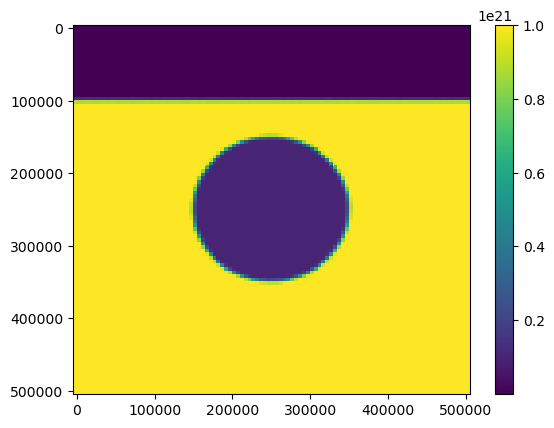

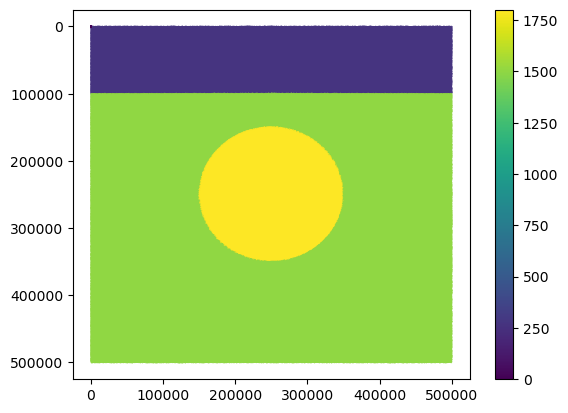

In [4]:
figure()
title(print(time/3.15e7))
pcolor(grid.xc,grid.yc,eta_n)
gca().invert_yaxis()
colorbar()
show()

figure()
scatter(markers.x[1,:],markers.x[2,:],c=markers.scalars[markers.scalarFields["T"],:],s=0.1)
gca().invert_yaxis()
colorbar()
show()

In [ ]:
using ProfileSVG
@profview run(10)